# Gibbs Sampling
We use Gibbs sampling to estimate expectations that would otherwise required summations over exponentially many states. To test our Gibbs sampling algorithm, we instantiate an exponential model of the form:
$$
P^{(3)}(\{\sigma_i\}) = \frac{1}{Z} \exp \left[ \sum_i h_i \sigma_i + \sum_{i< j} J_{ij}\sigma_i\sigma_j + \sum_{i<j<k} K_{ijk}\sigma_i\sigma_j\sigma_k  \right]
$$
by randomly sampling the interaction parameters $h,J,K$. We then compare expectations estimated from Gibbs sampling to the actual expectations of the distribution $p^{(3)}$. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from ThreeWise import ThreeWise

In [2]:
def sim_p_true(N, h_m=0.02, J_m=0.05, K_m=0.02, h=None, J=None, K=None):
    """
    Function that creates a distribution that includes up to 3-wise interactions, by randomly sampling the interaction weights if h,J,K set to None
    Otherwise, uses the provided interactions parameters.
    """
    if not isinstance(h,np.ndarray):
        h = np.zeros(N)
        for i in range(N):
            h[i] = -np.log(np.abs(1/np.random.exponential(h_m) - 1))
    
    if not isinstance(J,np.ndarray):  
        J = np.zeros((N,N))
        for i in range(N-1):
            for j in range(i+1,N):
                J[i,j] = np.random.normal(J_m, 0.8)
    
    if not isinstance(K,np.ndarray):
        K = np.zeros((N,N,N))
        for i in range(N-2):
            for j in range(i+1,N-1):
                for k in range(j+1,N):
                    K[i,j,k] = np.random.normal(K_m, 0.5)
    
    p_true = ThreeWise(N, h, J, K)
    return p_true

In [3]:
N = 5
p_true = sim_p_true(N,0.2,0.1,0.1)

In [4]:
print(p_true.averages(),"\n",p_true.correlations())

[0.03670735 0.09899664 0.05023226 0.00975642 0.29237838] 
 [[0.         0.00354805 0.00346987 0.00110187 0.01028605]
 [0.         0.         0.0059298  0.00065519 0.03161669]
 [0.         0.         0.         0.00023837 0.0136449 ]
 [0.         0.         0.         0.         0.00365139]
 [0.         0.         0.         0.         0.        ]]


In [39]:
def gibbs_sampling(p, M):
    """
    Given a probability distribution p, returns M samples using gibbs sampling
    Burn-in is not included, and we add states everytime a dimension is updated, hence states are very correlated.
    """
    N = p.N #no of states
    spin_vals = p.spin_vals #values that each variable can take on
    p_ind = p.averages()*(spin_vals[1]-spin_vals[0]) + spin_vals[0]

    samples = np.zeros((M,N))
    samples[0] = np.random.binomial(1,p_ind)*(spin_vals[1]-spin_vals[0]) + spin_vals[0] #set the initial state  
    for t in range(1,M): 
        samples[t] = samples[t-1]
        i = t % N #which dimension to work on
        state_off = np.copy(samples[t])
        state_on = np.copy(samples[t])
        state_off[i] =  spin_vals[0] #state with neuron i set to off
        state_on[i] = spin_vals[1] #state with neuron i
        p_on = p.p_unnormalized(state_on) 
        p_on = p_on / (p_on + p.p_unnormalized(state_off)) #calc cond prob that spin i is on given other spin vals
        if np.random.uniform() < p_on: #draw number from unif distribution to determine whether we update i
            samples[t]=state_on
            continue
        samples[t]=state_off
    return samples

## Perform sampling and compare sample expectations to true expectations

In [40]:
M = 100000
samples=gibbs_sampling(p_true, M)

In [41]:
means_true = p_true.averages()
dp = 5 #decimal places
print("True means", np.round(means_true,dp), "Sample means", np.round(np.mean(samples, axis=0),dp), sep="\n")
print("Difference in means", means_true - np.mean(samples,axis=0), sep="\n")

corrs_true = p_true.correlations()
corrs_sample = np.triu((samples.T@samples) / M,k=1)
print("True correlations", np.round(corrs_true,dp), "Sample correlations", np.round(corrs_sample,dp), sep="\n")
print("Difference in correlations", corrs_true - corrs_sample, sep="\n")

True means
[0.03671 0.099   0.05023 0.00976 0.29238]
Sample means
[0.03635 0.0995  0.0516  0.01005 0.2892 ]
Difference in means
[ 0.00035735 -0.00050336 -0.00136774 -0.00029358  0.00317838]
True correlations
[[0.      0.00355 0.00347 0.0011  0.01029]
 [0.      0.      0.00593 0.00066 0.03162]
 [0.      0.      0.      0.00024 0.01364]
 [0.      0.      0.      0.      0.00365]
 [0.      0.      0.      0.      0.     ]]
Sample correlations
[[0.      0.00351 0.00365 0.001   0.01001]
 [0.      0.      0.00614 0.00068 0.03025]
 [0.      0.      0.      0.00038 0.01422]
 [0.      0.      0.      0.      0.00387]
 [0.      0.      0.      0.      0.     ]]
Difference in correlations
[[ 0.00000000e+00  3.80504471e-05 -1.80132704e-04  1.01872837e-04
   2.76054027e-04]
 [ 0.00000000e+00  0.00000000e+00 -2.10201218e-04 -2.48107541e-05
   1.36668993e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.41632495e-04
  -5.75104470e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

## Determining burn-in and average over
We want to see what sort of burn-in we should include (how many of the initial states to discard from the average), as well as whether we might want average over every ith state. 

### Burn-in

In [42]:
b = 2000 -1 # how many burn-ins to consider
incr = 50 #how much increment each burn in
burn_ins = np.arange(b)*incr
error = np.zeros(b) #

for bi in range(b):
    error[bi] = np.sum( np.abs(np.mean(samples[burn_ins[bi]:],axis=0)-means_true))

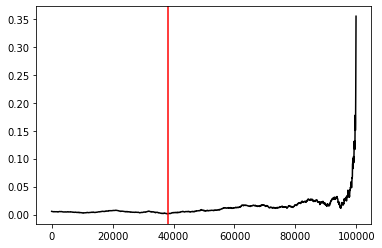

Min error at
38050
Means computed using burn-in
[0.03591606 0.09895077 0.05020178 0.00968523 0.2925908 ]
True means
[0.03670735 0.09899664 0.05023226 0.00975642 0.29237838]


In [43]:
plt.plot(burn_ins, error,"k")
min_error = np.argmin(error)
plt.axvline(burn_ins[min_error],color="r")
plt.show()
print("Min error at", burn_ins[min_error], "Means computed using burn-in", np.mean(samples[burn_ins[min_error]:],axis=0), "True means",means_true, sep="\n")

### Average over

In [44]:
av_over = [1,2,5,10,50]
error = np.zeros(len(av_over))

for ai in range(len(av_over)):
    error[ai] = np.sum( np.abs(np.mean(samples.reshape(av_over[ai],-1,N)[0],axis=0)-means_true) )

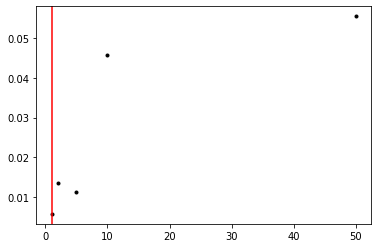

Means produced by averageing over every 1 sample
[0.03635 0.0995  0.0516  0.01005 0.2892 ]
True means
[0.03670735 0.09899664 0.05023226 0.00975642 0.29237838]


In [45]:
plt.plot(av_over, error,"k.")
min_error = np.argmin(error)
plt.axvline(av_over[min_error],color="r")
plt.show()
print(f"Means produced by averageing over every {av_over[min_error]} sample", np.mean(samples.reshape(av_over[min_error],-1,N)[0],axis=0), "True means",means_true, sep="\n")